Best parameters found: {'ensemble__ridge__alpha': 0.01, 'ensemble__sgd__alpha': 0.0001, 'ensemble__sgd__max_iter': 1000}
Training MSE: 3.593900429204597e-05
Training MAE: 0.0037559888310013047
Training R^2: 0.9999999987723371
Testing MSE: 1207.6336088956812
Testing MAE: 23.967042268471282
Testing R^2: 0.89397874443927
Cross-Validated MSE: 4913.574059020834
Cross-Validated MAE: 33.04508497148289
Cross-Validated R^2: 0.7925199093325169


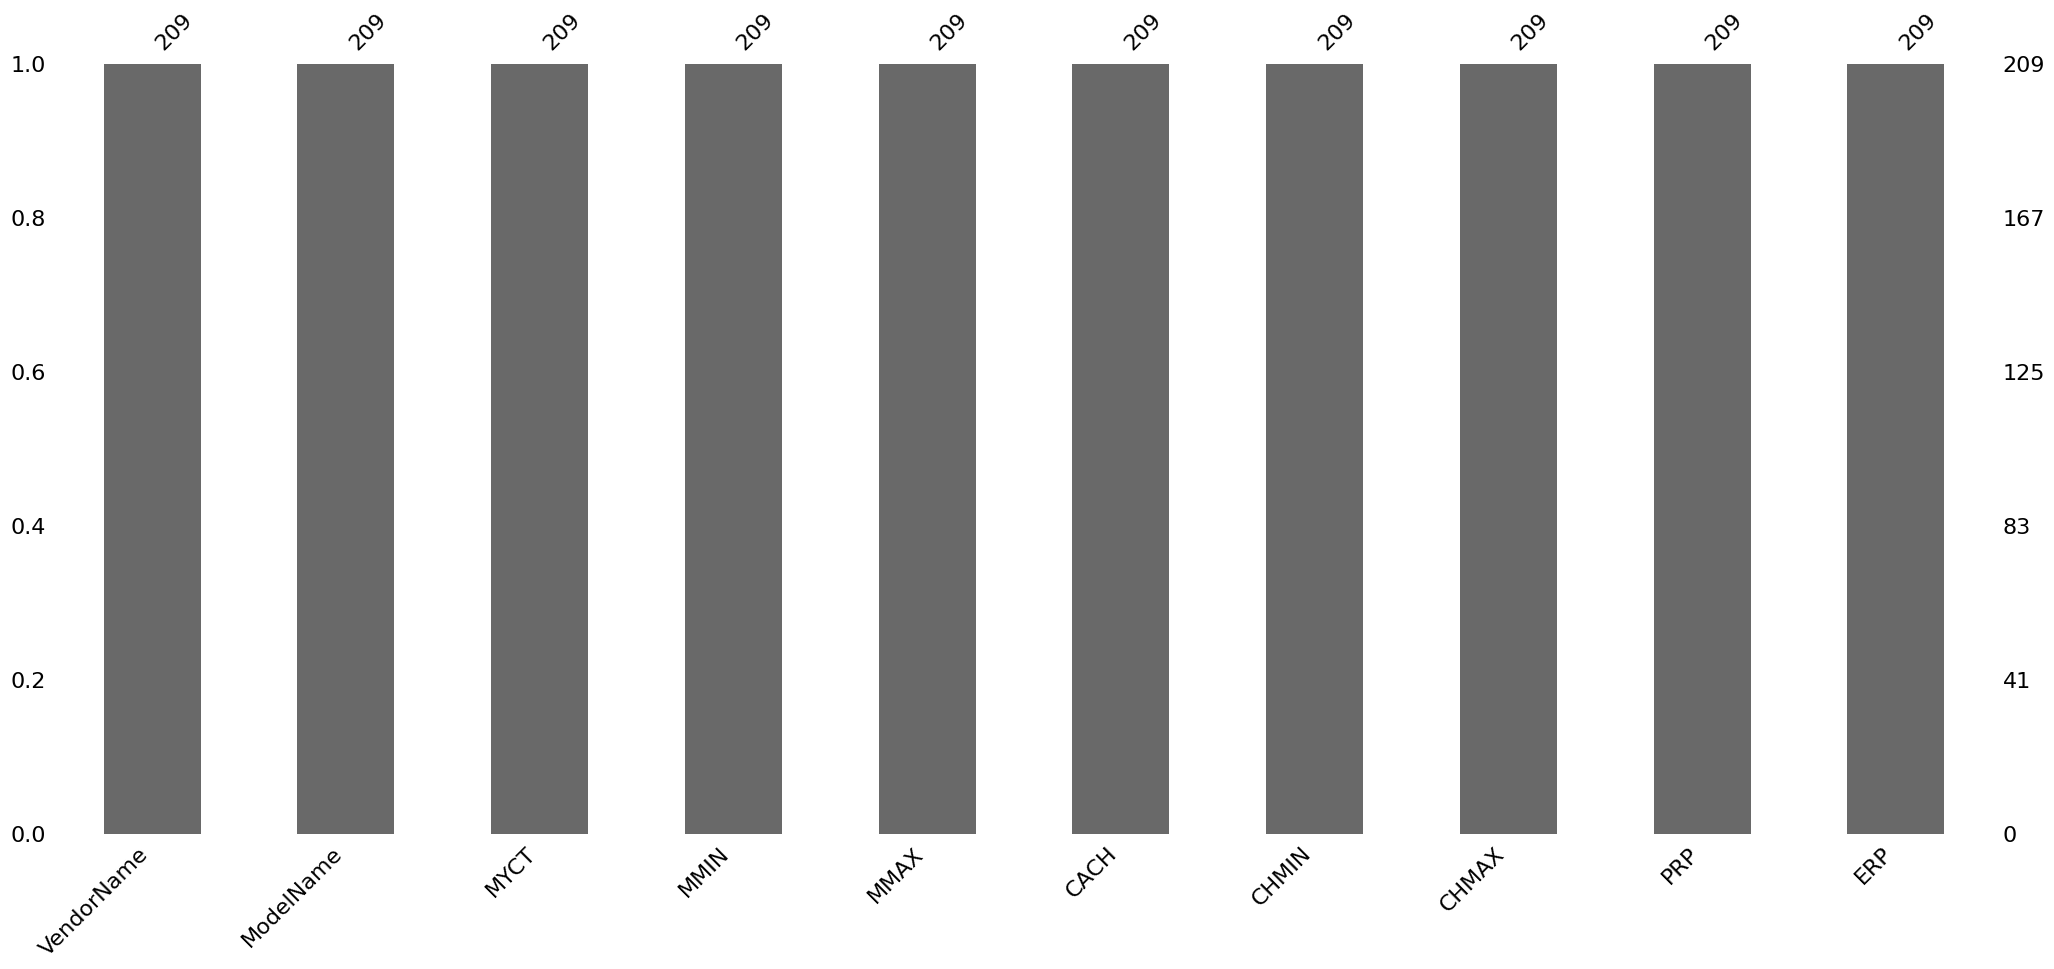

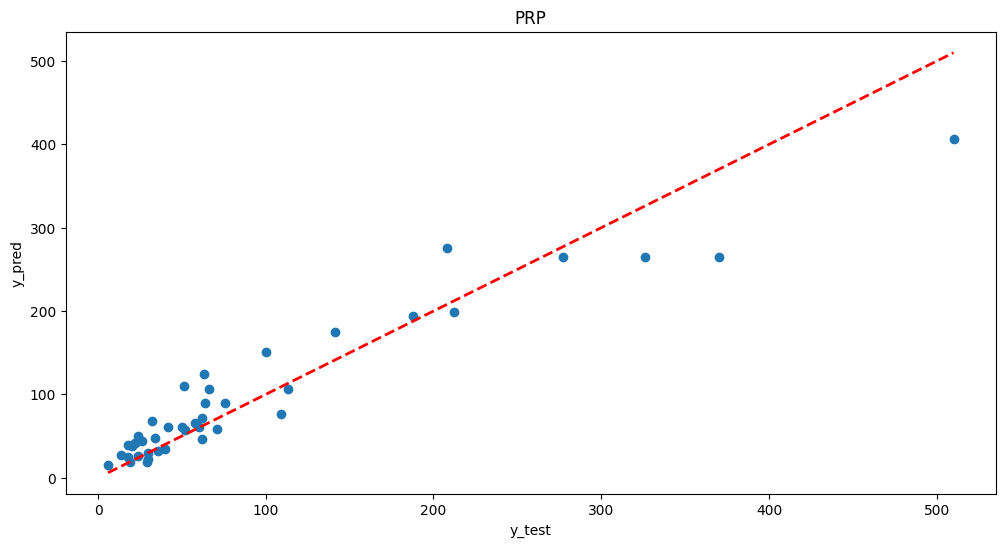

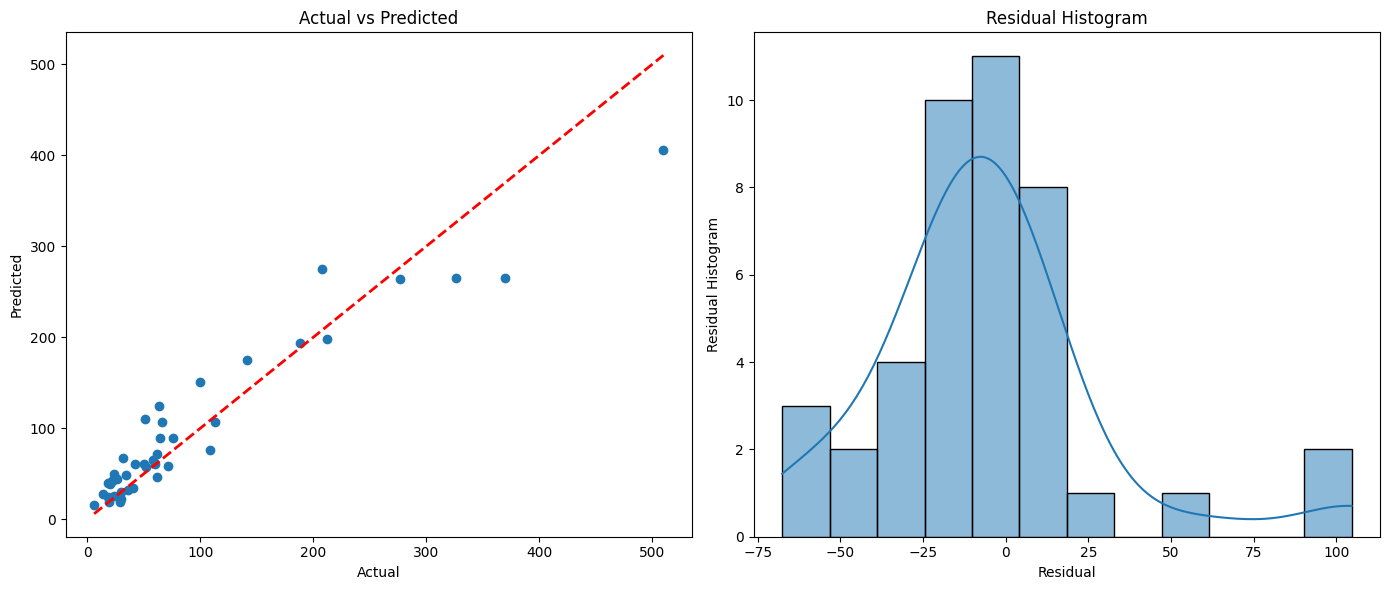

In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import SGDRegressor, LinearRegression, Ridge
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler
import missingno as msn
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import VotingRegressor

# 데이터 로드 및 전처리
life = pd.read_csv("./machine.data_update.csv")

# 결측값 찾기
msn.bar(life)  # 결측값 시각화

# 결측치 처리
life.dropna(inplace=True)  # 결측값이 있는 행 제거

# 범주형 데이터 수치화
dum = pd.get_dummies(life.VendorName, prefix='c', dtype=float)  # VendorName을 원-핫 인코딩
life = pd.concat([life.drop('VendorName', axis=1), dum], axis=1)

dum = pd.get_dummies(life.ModelName, prefix='c', dtype=float)  # ModelName을 원-핫 인코딩
life = pd.concat([life.drop('ModelName', axis=1), dum], axis=1)

# PRP 관련된 다른 특성들과의 상관계수 값만을 출력
result = life.corr()['PRP']

# 상관계수 값을 양의 상관계수로 처리
result = np.abs(result)

# 상관계수를 내림차순으로 정렬하기
result.sort_values(ascending=False)

# 피처 선택
features = result.index.tolist()
features.remove('PRP')  # 목표 변수를 제거

# x, y 값 지정 및 데이터 분류
X = life[features]  # 특성 변수들
y = life['PRP']  # 목표 변수
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=38)  # 데이터 분할

# 피처추출
numeric_features = X_train.select_dtypes(include=['int64', 'float64']).columns  # 수치형 피처 추출

# 데이터의 전처리 - 파이프라인 설정
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())  # 특성의 평균을 빼고 표준편차로 나누어 각 특성의 분포를 평균 0, 표준편차 1로 만듬
])

# 전처리를 수행
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features)
    ]
)

# 개별 모델 정의
models = [
    ('lr', LinearRegression()),  # 선형 회귀
    ('sgd', SGDRegressor()),  # 확률적 경사 하강법 회귀
    ('ridge', Ridge())  # 릿지 회귀
]

# 앙상블 모델 정의
ensemble = VotingRegressor(estimators=models)  # 앙상블 모델 정의 (투표 방식)

# 모델 파이프라인 생성
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),  # 전처리 단계 추가
    ('ensemble', ensemble)  # 앙상블 모델 추가
])

# 하이퍼파라미터 튜닝
param_grid = {
    'ensemble__sgd__alpha': [0.0001, 0.1, 1.0],
    'ensemble__sgd__max_iter': [1000, 2000, 3000],
    'ensemble__ridge__alpha': [0.01, 0.1, 1.0, 10.0]
}

# GridSearchCV 설정 및 모델 학습
grid_search = GridSearchCV(model_pipeline, param_grid, cv=5, scoring='neg_mean_squared_error', return_train_score=True)
grid_search.fit(X_train, y_train)

# 최적 파라미터 출력
print(f"Best parameters found: {grid_search.best_params_}")

# 최적 모델로 예측
best_model = grid_search.best_estimator_

# 모델 평가 - 학습 데이터
y_train_pred = best_model.predict(X_train)
train_mse = mean_squared_error(y_train, y_train_pred)
train_mae = mean_absolute_error(y_train, y_train_pred)
train_r2 = r2_score(y_train, y_train_pred)

# 모델 평가 - 테스트 데이터
y_test_pred = best_model.predict(X_test)
test_mse = mean_squared_error(y_test, y_test_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)

print(f"Training MSE: {train_mse}")
print(f"Training MAE: {train_mae}")
print(f"Training R^2: {train_r2}")

print(f"Testing MSE: {test_mse}")
print(f"Testing MAE: {test_mae}")
print(f"Testing R^2: {test_r2}")

# 교차 검증
cv_score = cross_val_score(best_model, X, y, cv=5, scoring='r2')
cv_mse = cross_val_score(best_model, X, y, cv=5, scoring='neg_mean_squared_error').mean()
cv_mae = cross_val_score(best_model, X, y, cv=5, scoring='neg_mean_absolute_error').mean()
cv_r2 = cv_score.mean()

print(f'Cross-Validated MSE: {-cv_mse}')
print(f'Cross-Validated MAE: {-cv_mae}')
print(f'Cross-Validated R^2: {cv_r2}')

# 시각화
plt.figure(figsize=(12, 6))
plt.scatter(y_test, y_test_pred)  # 실제값 vs 예측값 산점도
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)  # 대각선 기준선
plt.xlabel("y_test")
plt.ylabel("y_pred")
plt.title("PRP")
plt.savefig('PRP.jpg')

plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.scatter(y_test, y_test_pred)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual')
plt.ylabel("Predicted")
plt.title('Actual vs Predicted')

plt.subplot(1, 2, 2)
sns.histplot(y_test - y_test_pred, kde=True)  # 잔차 히스토그램
plt.xlabel('Residual')
plt.ylabel('Residual Histogram')
plt.title('Residual Histogram')
plt.tight_layout()
plt.show()


                                Model              Data           MSE  \
0                   Linear Regression             Train  4.072586e-26   
1                   Linear Regression              Test  1.080490e+03   
2                      Best_estimator             Train  3.785841e-05   
3                      Best_estimator              Test  1.207615e+03   
4  Linear Regression Cross Validation  Cross Validation  3.744913e+03   
5     Best_estimator Cross Validation  Cross Validation  4.913575e+03   

            MAE       R^2  
0  1.461080e-13  1.000000  
1  2.457596e+01  0.905141  
2  4.724812e-03  1.000000  
3  2.396659e+01  0.893980  
4  3.419534e+01  0.787209  
5  3.304519e+01  0.792521  


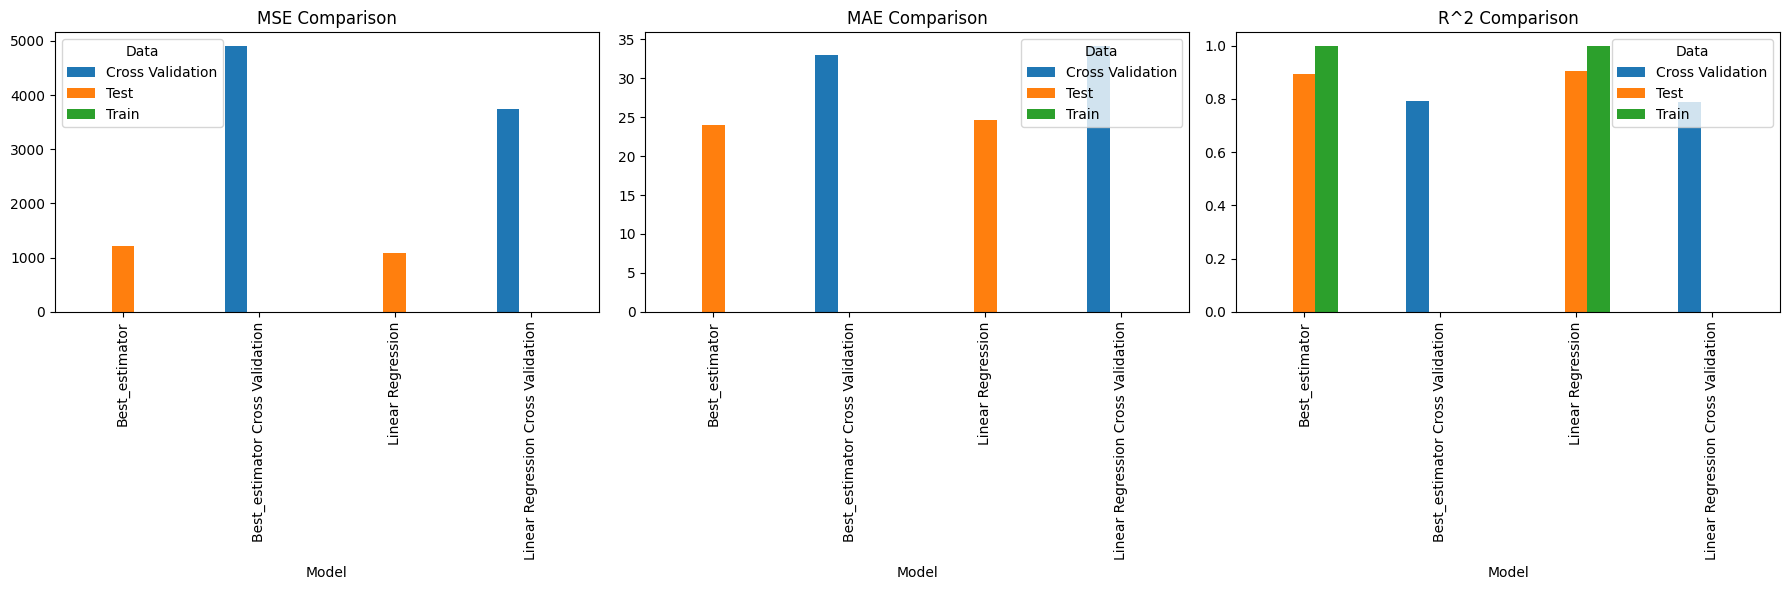

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import VotingRegressor
from sklearn.linear_model import Ridge

# 데이터 로드 및 전처리
life = pd.read_csv("./machine.data_update.csv")
life.dropna(inplace=True)  # 결측값 있는 행 제거

# 범주형 데이터 수치화
dum = pd.get_dummies(life.VendorName, prefix='c', dtype=float)  # VendorName을 원-핫 인코딩
life = pd.concat([life.drop('VendorName', axis=1), dum], axis=1)

dum = pd.get_dummies(life.ModelName, prefix='c', dtype=float)  # ModelName을 원-핫 인코딩
life = pd.concat([life.drop('ModelName', axis=1), dum], axis=1)

# 상관계수 계산 및 피처 선택
result = np.abs(life.corr()['PRP'])  # PRP와의 절대 상관계수 계산
features = result.index.tolist()
features.remove('PRP')  # 목표 변수를 제거

# 데이터 분할
X = life[features]
y = life['PRP']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=38)

# 선형 회귀 모델
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

model = LinearRegression()
model.fit(X_train_scaled, y_train)

# 모델 평가 - 학습 데이터
y_train_pred = model.predict(X_train_scaled)
lr_train_mse = mean_squared_error(y_train, y_train_pred)
lr_train_mae = mean_absolute_error(y_train, y_train_pred)
lr_train_r2 = r2_score(y_train, y_train_pred)

# 모델 평가 - 테스트 데이터
y_test_pred = model.predict(X_test_scaled)
lr_test_mse = mean_squared_error(y_test, y_test_pred)
lr_test_mae = mean_absolute_error(y_test, y_test_pred)
lr_test_r2 = r2_score(y_test, y_test_pred)

# 교차 검증 - 선형 회귀 모델
cv_score = cross_val_score(model, X, y, cv=5, scoring='r2')
cv_mse = cross_val_score(model, X, y, cv=5, scoring='neg_mean_squared_error').mean()
cv_mae = cross_val_score(model, X, y, cv=5, scoring='neg_mean_absolute_error').mean()
cv_r2 = cv_score.mean()

# 피처 스케일링 파이프라인 설정
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())  # 수치형 피처 표준화
])

# 전처리 수행
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, features)  # 수치형 피처에 대한 전처리
    ]
)

# 개별 모델 정의
models = [
    ('lr', LinearRegression()),  # 선형 회귀
    ('sgd', SGDRegressor()),  # 확률적 경사 하강법 회귀
    ('ridge', Ridge())  # 릿지 회귀
]

# 앙상블 모델 정의
ensemble = VotingRegressor(estimators=models)  # 앙상블 모델 정의 (투표 방식)

# 모델 파이프라인 생성
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),  # 전처리 단계 추가
    ('ensemble', ensemble)  # 앙상블 모델 추가
])

# 하이퍼파라미터 튜닝
param_grid = {
    'ensemble__sgd__alpha': [0.0001, 0.1, 1.0],
    'ensemble__sgd__max_iter': [1000, 2000, 3000],
    'ensemble__ridge__alpha': [0.01, 0.1, 1.0, 10.0]
}

# GridSearchCV 설정 및 모델 학습
grid_search = GridSearchCV(model_pipeline, param_grid, cv=5, scoring='neg_mean_squared_error', return_train_score=True)
grid_search.fit(X_train, y_train)

# 최적 모델
best_model = grid_search.best_estimator_

# 최적 모델 평가 - 학습 데이터
y_traning_pred = best_model.predict(X_train)
pipe_traning_mse = mean_squared_error(y_train, y_traning_pred)
pipe_traning_mae = mean_absolute_error(y_train, y_traning_pred)
pipe_traning_r2 = r2_score(y_train, y_traning_pred)

# 최적 모델 평가 - 테스트 데이터
y_pred = best_model.predict(X_test)
pipe_test_mse = mean_squared_error(y_test, y_pred)
pipe_test_mae = mean_absolute_error(y_test, y_pred)
pipe_test_r2 = r2_score(y_test, y_pred)

# 최적 모델 교차 검증
best_cv_score = cross_val_score(best_model, X, y, cv=5, scoring='r2')
best_cv_mse = cross_val_score(best_model, X, y, cv=5, scoring='neg_mean_squared_error').mean()
best_cv_mae = cross_val_score(best_model, X, y, cv=5, scoring='neg_mean_absolute_error').mean()
best_cv_r2 = best_cv_score.mean()

# 결과를 DataFrame으로 생성
results = pd.DataFrame({
    'Model': ['Linear Regression', 'Linear Regression', 'Best_estimator', 'Best_estimator', 'Linear Regression Cross Validation', 'Best_estimator Cross Validation'],
    'Data': ['Train', 'Test', 'Train', 'Test', 'Cross Validation', 'Cross Validation'],
    'MSE': [lr_train_mse, lr_test_mse, pipe_traning_mse, pipe_test_mse, -cv_mse, -best_cv_mse],
    'MAE': [lr_train_mae, lr_test_mae, pipe_traning_mae, pipe_test_mae, -cv_mae, -best_cv_mae],
    'R^2': [lr_train_r2, lr_test_r2, pipe_traning_r2, pipe_test_r2, cv_r2, best_cv_r2]
})
print(results)

# 결과 시각화
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 6))

# MSE 비교
results.pivot(index='Model', columns='Data', values='MSE').plot(kind='bar', ax=axes[0], title='MSE Comparison')

# MAE 비교
results.pivot(index='Model', columns='Data', values='MAE').plot(kind='bar', ax=axes[1], title='MAE Comparison')

# R^2 비교
results.pivot(index='Model', columns='Data', values='R^2').plot(kind='bar', ax=axes[2], title='R^2 Comparison')

plt.tight_layout()
plt.show()
